In [81]:
import tensorflow as tf
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [77]:
data_dir = './dataset/'
batch_size = 32
img_height = 256
img_width = 256
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
 
# image_count = len(list(data_dir.glob('*/*.jpg')))
# print(image_count)

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=SEED,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=SEED,
  image_size=(img_height, img_width),
  batch_size=batch_size)


# df = pd.read_table('./dataset/captcha_data.csv', sep=',', dtype={'solution': str})

Found 5631 files belonging to 4 classes.
Using 4505 files for training.
Found 5631 files belonging to 4 classes.
Using 1126 files for validation.


In [78]:
class_names = train_ds.class_names
print(class_names)

['cloudy', 'desert', 'green_area', 'water']


(32, 256, 256, 3)
(32,)


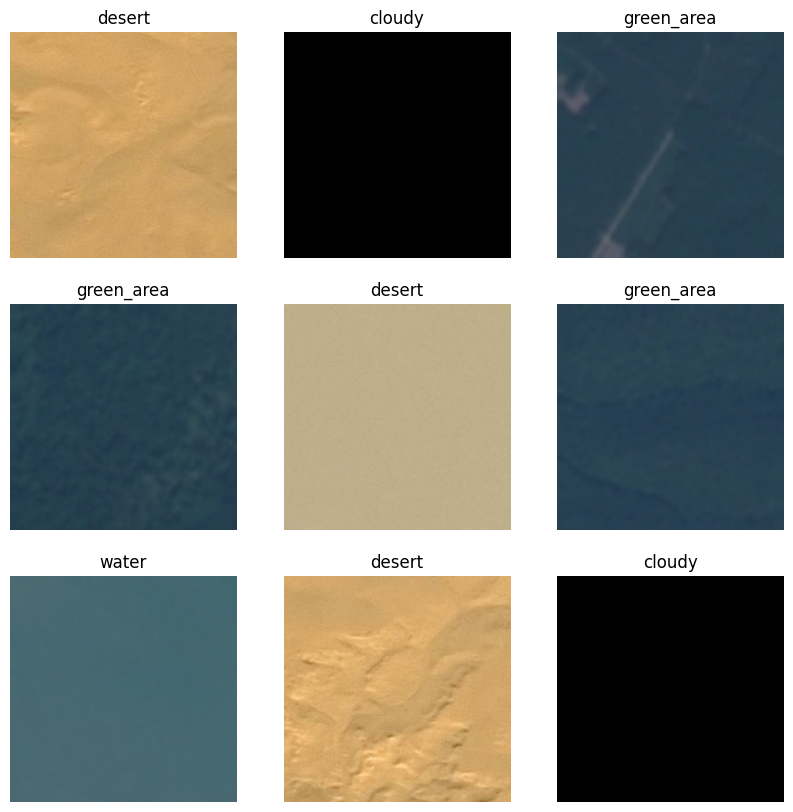

In [83]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [101]:
num_classes = 4

def create_cnn_model(input_shape=(256, 256, 3)):
    # Build the model
    model = models.Sequential()
    model.add(Rescaling(1./255, input_shape=input_shape))
    # Convolutional layers
    model.add(Conv2D(512, 3, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, 3, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, 3, activation='relu'))
    model.add(MaxPooling2D())
    # Flatten the output of the convolutional layers
    model.add(Flatten())
    # Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes))
    
    # model.compile(optimizer='adam',
    #           loss='sparse_categorical_crossentropy',  # Use sparse categorical loss
            #   metrics=['accuracy'])
    # optimizer = SGD(learning_rate=0.002, momentum=0.8)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn_model()
cnn_model.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_12 (Rescaling)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 254, 254, 512)  │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_84 (MaxPooling2D) │ (None, 127, 127, 512)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 125, 125, 256)  │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_85 (MaxPooling2D) │ (None, 62, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 60, 60, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_86 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 64)             │     7,372,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,862,404 (33.81 MB)

 Trainable params: 8,862,404 (33.81 MB)

 Non-trainable params: 0 (0.00 B)

In [102]:
history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30
)

Epoch 1/30


2025-01-12 22:16:12.250780: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at xla_ops.cc:577 : UNKNOWN: Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.9 = (f32[32,512,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0} %multiply.48, f32[512,3,3,3]{3,2,1,0} %bitcast.1786, f32[512]{0} %arg3.4), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_29_1/conv2d_84_1/convolution" source_file="/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1196}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 4244897792 bytes.

T

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_71742/1521651816.py", line 1, in <module>

  File "/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 368, in fit

  File "/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 216, in function

  File "/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 129, in multi_step_on_iterator

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.9 = (f32[32,512,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0} %multiply.48, f32[512,3,3,3]{3,2,1,0} %bitcast.1786, f32[512]{0} %arg3.4), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_29_1/conv2d_84_1/convolution" source_file="/home/freillat/projects/tf217/tf217/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1196}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 4244897792 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_264893]